In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [14]:
df=pd.read_csv('song_data_processed.csv')
df.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_7,key_8,key_9,key_10,key_11,audio_mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,0.0294,167.060,...,False,True,False,False,False,True,False,False,True,False
1,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,0.0498,105.256,...,False,False,False,False,False,False,False,False,True,False
2,76,231733,0.008170,0.737,0.463,0.447000,0.2550,-7.828,0.0792,123.881,...,False,False,False,False,False,True,False,False,True,False
3,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,0.1070,122.444,...,False,False,False,False,False,True,False,False,True,False
4,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,0.0313,172.011,...,False,False,False,True,False,True,False,False,True,False


In [15]:
def split_and_scale_data(song_data, features, target='song_popularity', test_size=0.2, random_state=1):
    """
    Splits the data into training and testing sets and scales the features.
    
    Parameters:
    song_data (DataFrame): The dataset containing features and target variable.
    features (list): List of feature column names.
    target (str): The target variable column name. Default is 'song_popularity'.
    test_size (float): The proportion of the dataset to include in the test split. Default is 0.2.
    random_state (int): Random seed for reproducibility. Default is 1.
    
    Returns:
    tuple: Scaled training and testing features, and training and testing target variables.
    """
    
    # Splitting the data
    X = song_data[features]
    y = song_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [16]:
features = df.columns.drop('song_popularity')

X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale_data(df, features, random_state=2024)
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_scaled shape: (11940, 26)
X_test_scaled shape: (2986, 26)
y_train shape: (11940,)
y_test shape: (2986,)


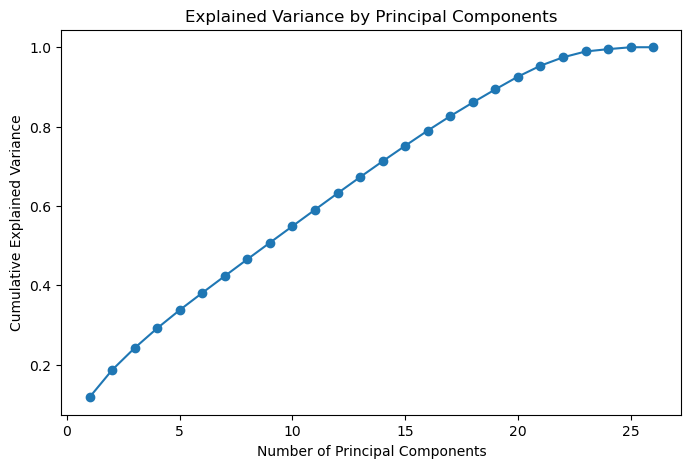

In [17]:
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df.drop(columns=['song_popularity']))

# Apply PCA
pca = PCA().fit(X_train_scaled)
pca_result = pca.fit_transform(normalized_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Determine feature importance
loadings = pd.DataFrame(pca.components_, columns=df.columns[1:], index=[f'PC{i+1}' for i in range(len(pca.components_))])

In [18]:
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [1.17582087e-01 6.86662282e-02 5.55180490e-02 4.97813796e-02
 4.59209469e-02 4.32120391e-02 4.25650736e-02 4.22546749e-02
 4.17459457e-02 4.16459659e-02 4.15465498e-02 4.13648422e-02
 4.08112418e-02 3.99450797e-02 3.90398450e-02 3.82764220e-02
 3.64863623e-02 3.43154816e-02 3.31949308e-02 3.19826410e-02
 2.75632997e-02 2.11488181e-02 1.47107406e-02 5.88076541e-03
 4.77689765e-03 6.36929056e-05]


In [11]:
correlations = df.corr()
print(correlations['song_popularity'].sort_values(ascending=False))

song_popularity     1.000000
danceability        0.056415
loudness            0.052114
key_1               0.031264
time_signature_4    0.022226
key_6               0.020305
audio_mode_1        0.008824
key_11              0.008603
key_10              0.007812
time_signature_5    0.001493
key_5              -0.000070
speechiness        -0.001971
key_8              -0.002629
key_4              -0.007740
song_duration_ms   -0.007766
time_signature_1   -0.009507
key_3              -0.010737
key_2              -0.011771
key_9              -0.015307
key_7              -0.015710
energy             -0.016468
time_signature_3   -0.023153
tempo              -0.029560
acousticness       -0.031658
liveness           -0.038553
audio_valence      -0.043963
instrumentalness   -0.093032
Name: song_popularity, dtype: float64


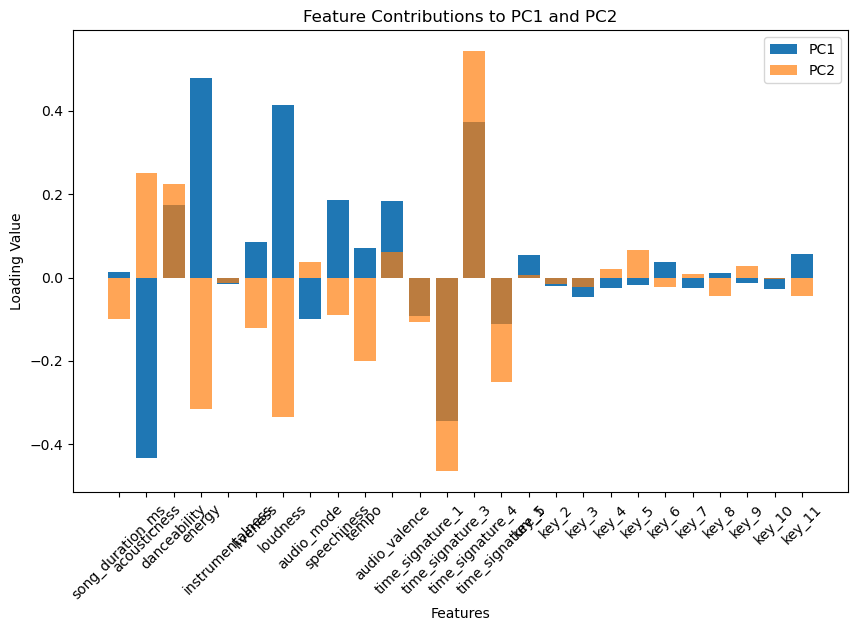

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(loadings.columns, loadings.loc['PC1'], label='PC1')
plt.bar(loadings.columns, loadings.loc['PC2'], label='PC2', alpha=0.7)
plt.xticks(rotation=45)
plt.title('Feature Contributions to PC1 and PC2')
plt.xlabel('Features')
plt.ylabel('Loading Value')
plt.legend()
plt.show()


In [ ]:
# Use retained PCs as predictors
retained_pcs = pca_result  
reg = LinearRegression()
reg.fit(retained_pcs, df['song_popularity'])

print("Regression coefficients for PCs:", reg.coef_)

Regression coefficients for PCs: [ 5.57525615e-01 -1.25412424e-01  5.86634294e-01 -6.45926424e-01
  1.56060434e+00  8.20735218e-02  2.13780505e-01  1.99887025e-01
  3.63030394e-01  1.20349194e-01 -2.12059519e-01 -1.01794401e-01
  9.43373498e-02 -3.82443631e-01 -1.78169706e-01  4.65462172e-01
 -7.30235408e-01 -8.29828665e-01  3.40902661e-01 -6.65841608e-01
  9.57034695e-01  2.39482296e+00  1.46788215e+00 -2.77727828e+00
  7.45858501e-02  9.58115875e-16]


## Choose Principle Components

Performace of Random Forest Model on different number of Principle Component

In [ ]:
def random_forest_RMSE(normalized_data, X_train_scaled, y_train, y_test):
    mse_values = []

    target = df['song_popularity']
    for i in range(27):
        pca = PCA(n_components=i)  

        model = RandomForestClassifier()
        model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        mse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # accuracy = model.score(X_test, y_test)
        mse_values.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 28), mse_values, marker='o', linestyle='-', color='b')
    plt.title('MSE vs Number of Principle Components', fontsize=14)
    plt.xlabel('Number of PCA Components', fontsize=12)
    plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
    plt.xticks(range(1, 28))
    plt.grid(alpha=0.5)
    plt.show()

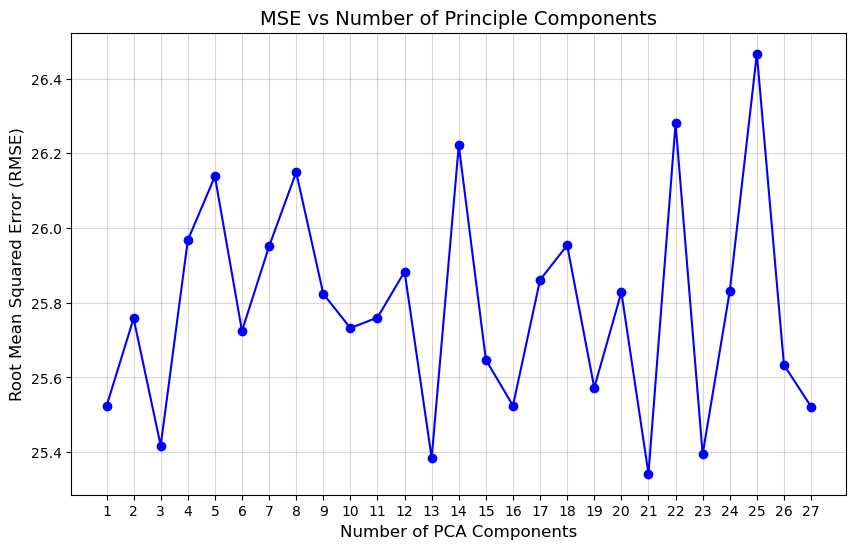

In [22]:
random_forest_RMSE(normalized_data, X_train_scaled, y_train, y_test)